# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.autograd import Variable

from torchvision import datasets, transforms
import torchvision

import sys, os
import matplotlib.pyplot as plt

import custom_resnet
import resnet

from utils import create_train_data_loader, create_test_data_loader
from utils import Cifar10SearchDataset
from utils import train_transforms, test_transforms
from utils import display_mis_images 
from utils import learning_r_finder
from utils import OneCycleLR_policy
from utils import get_misclassified_data

from calc_loss_accuracy import model_training, model_testing 
from plots import plot_losses,plot_images 

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.8/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
### this is for running in local ###
try:
    os.environ['HTTP_PROXY']='http://185.46.212.90:80'
    os.environ['HTTPS_PROXY']='http://185.46.212.90:80'
    print ("proxy_exported")
except:
    None

proxy_exported


In [3]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    
device = torch.device("cuda" if cuda else "cpu")
print(device)

CUDA Available? True
cuda


# Train/Test Data Loaders with Transformation

In [4]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

train_transforms = train_transforms(means, stds)
test_transforms = test_transforms(means, stds)

train = Cifar10SearchDataset('./data', train=True, download=True, transform=train_transforms)
test = Cifar10SearchDataset('./data', train=False, download=True, transform=test_transforms)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


# Model Params, optimizer, loss criterion and model summary
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [5]:
m = resnet.ResNet18().to(device)
optimizer = optim.Adam(m.parameters(), lr=0.001, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
summary(m, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## Calculating the max and min LR using one cycle LR policy

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.59E-03


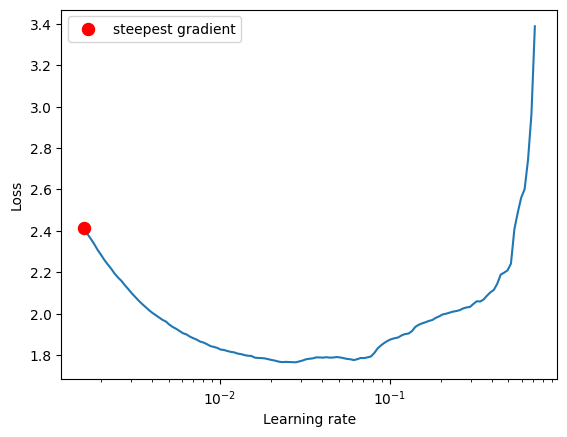

In [6]:
 # to reset the model and optimizer to their initial state
learning_r_finder(m,optimizer,criterion, device, train_loader, n_iters=200,  end_lr=10)
# sys.exit()

# Let's Train and test our model
### using one cycle lr policy

In [7]:
EPOCHS = 20
scheduler = OneCycleLR_policy(optimizer,train_loader,EPOCHS,peak_value=5.0,div_factor=100,final_div_factor=100,max_lr=1.83E-03)

In [8]:
for epoch in range(EPOCHS):
    print("EPOCH: "+ str(epoch)),
    train_acc,train_losses = model_training(m, device, train_loader, optimizer, scheduler, criterion)
    test_acc,test_losses = model_testing(m, device, test_loader, criterion)

EPOCH: 0


Loss=1.3207887411117554 LR =0.00038138098159509206 Batch_id=97 Accuracy=39.06: 100% 98/98 [00:10<00:00,  9.20it/s]



Test set: Average loss: 0.0029, Accuracy: 5054/10000 (50.54%)

EPOCH: 1


Loss=1.2110376358032227 LR =0.000744461963190184 Batch_id=97 Accuracy=55.36: 100% 98/98 [00:10<00:00,  9.28it/s]  



Test set: Average loss: 0.0034, Accuracy: 4848/10000 (48.48%)

EPOCH: 2


Loss=0.9234654307365417 LR =0.001107542944785276 Batch_id=97 Accuracy=63.55: 100% 98/98 [00:10<00:00,  9.28it/s] 



Test set: Average loss: 0.0021, Accuracy: 6508/10000 (65.08%)

EPOCH: 3


Loss=0.8751621246337891 LR =0.0014706239263803681 Batch_id=97 Accuracy=67.66: 100% 98/98 [00:10<00:00,  9.22it/s]



Test set: Average loss: 0.0025, Accuracy: 5978/10000 (59.78%)

EPOCH: 4


Loss=0.8465850353240967 LR =0.0018287552265306122 Batch_id=97 Accuracy=70.33: 100% 98/98 [00:10<00:00,  9.27it/s]



Test set: Average loss: 0.0017, Accuracy: 7178/10000 (71.78%)

EPOCH: 5


Loss=0.673438549041748 LR =0.0017067674265306124 Batch_id=97 Accuracy=73.13: 100% 98/98 [00:10<00:00,  9.30it/s] 



Test set: Average loss: 0.0019, Accuracy: 6742/10000 (67.42%)

EPOCH: 6


Loss=0.6725563406944275 LR =0.0015847796265306122 Batch_id=97 Accuracy=75.28: 100% 98/98 [00:10<00:00,  9.22it/s]



Test set: Average loss: 0.0018, Accuracy: 7098/10000 (70.98%)

EPOCH: 7


Loss=0.7264063954353333 LR =0.0014627918265306124 Batch_id=97 Accuracy=76.99: 100% 98/98 [00:10<00:00,  9.20it/s]



Test set: Average loss: 0.0014, Accuracy: 7648/10000 (76.48%)

EPOCH: 8


Loss=0.6240062713623047 LR =0.0013408040265306123 Batch_id=97 Accuracy=78.35: 100% 98/98 [00:10<00:00,  9.26it/s]



Test set: Average loss: 0.0015, Accuracy: 7461/10000 (74.61%)

EPOCH: 9


Loss=0.6112078428268433 LR =0.0012188162265306121 Batch_id=97 Accuracy=79.47: 100% 98/98 [00:10<00:00,  9.20it/s]



Test set: Average loss: 0.0011, Accuracy: 8166/10000 (81.66%)

EPOCH: 10


Loss=0.5465733408927917 LR =0.0010968284265306123 Batch_id=97 Accuracy=80.69: 100% 98/98 [00:10<00:00,  9.31it/s] 



Test set: Average loss: 0.0011, Accuracy: 8130/10000 (81.30%)

EPOCH: 11


Loss=0.575975775718689 LR =0.0009748406265306123 Batch_id=97 Accuracy=81.95: 100% 98/98 [00:10<00:00,  9.37it/s]  



Test set: Average loss: 0.0011, Accuracy: 8266/10000 (82.66%)

EPOCH: 12


Loss=0.5232504606246948 LR =0.0008528528265306123 Batch_id=97 Accuracy=82.78: 100% 98/98 [00:10<00:00,  9.38it/s] 



Test set: Average loss: 0.0013, Accuracy: 7826/10000 (78.26%)

EPOCH: 13


Loss=0.48313263058662415 LR =0.0007308650265306122 Batch_id=97 Accuracy=83.68: 100% 98/98 [00:10<00:00,  9.44it/s]



Test set: Average loss: 0.0009, Accuracy: 8564/10000 (85.64%)

EPOCH: 14


Loss=0.44008809328079224 LR =0.0006088772265306123 Batch_id=97 Accuracy=84.75: 100% 98/98 [00:10<00:00,  9.17it/s]



Test set: Average loss: 0.0008, Accuracy: 8610/10000 (86.10%)

EPOCH: 15


Loss=0.43029725551605225 LR =0.00048688942653061216 Batch_id=97 Accuracy=85.88: 100% 98/98 [00:10<00:00,  9.19it/s]



Test set: Average loss: 0.0007, Accuracy: 8744/10000 (87.44%)

EPOCH: 16


Loss=0.32827508449554443 LR =0.00036490162653061227 Batch_id=97 Accuracy=87.11: 100% 98/98 [00:10<00:00,  9.36it/s]



Test set: Average loss: 0.0007, Accuracy: 8895/10000 (88.95%)

EPOCH: 17


Loss=0.36601781845092773 LR =0.00024291382653061238 Batch_id=97 Accuracy=88.55: 100% 98/98 [00:10<00:00,  9.35it/s]



Test set: Average loss: 0.0007, Accuracy: 8874/10000 (88.74%)

EPOCH: 18


Loss=0.3053596317768097 LR =0.00012092602653061228 Batch_id=97 Accuracy=89.88: 100% 98/98 [00:10<00:00,  9.42it/s] 



Test set: Average loss: 0.0005, Accuracy: 9108/10000 (91.08%)

EPOCH: 19


Loss=0.33885636925697327 LR =-1.061773469387614e-06 Batch_id=97 Accuracy=91.23: 100% 98/98 [00:10<00:00,  9.29it/s]



Test set: Average loss: 0.0005, Accuracy: 9224/10000 (92.24%)



## Displaying Train Test Accuracy and Loss Plots

mkdir: cannot create directory ‘images’: File exists


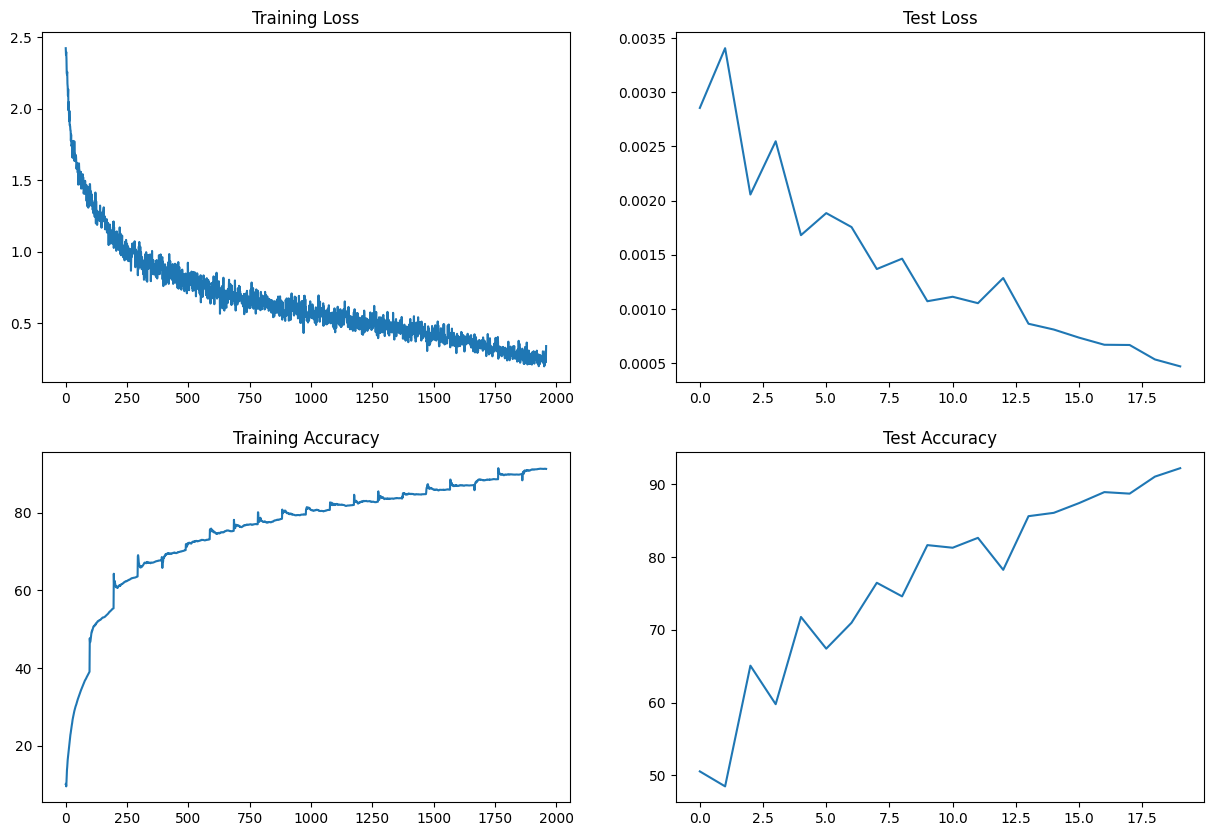

In [9]:
os.system('mkdir images')
fig = plot_losses(train_losses, train_acc, test_losses, test_acc)
fig.savefig('images/Accuracy & Loss.jpg')

## Displaying Sample Miss Classified Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

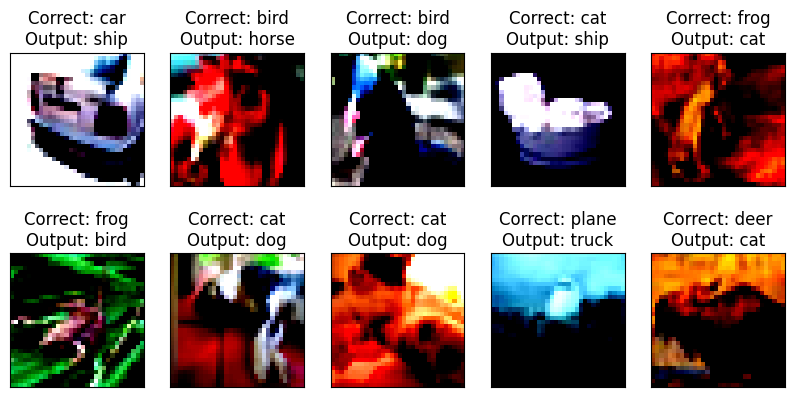

In [10]:
# Get the misclassified data from test dataset
misclassified_data = get_misclassified_data(m, device, test_loader)
miss_classified_images = display_mis_images(misclassified_data,10, classes)
miss_classified_images.savefig("images/miss_class.jpg")
#misclassified_data.savefig("images/miss_class.jpg")

## Displaying Sample Train Dataset after trasformation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

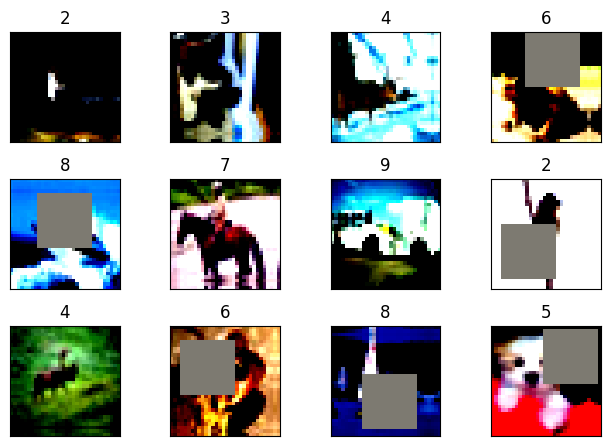

In [11]:
batch_data_train, batch_label_train = next(iter(train_loader))
figure_train = plot_images(batch_data_train, batch_label_train.tolist(), 12, 3, 'CIFAR10')
figure_train.savefig("images/train_dataset.jpg")

## Displaying Sample Test Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

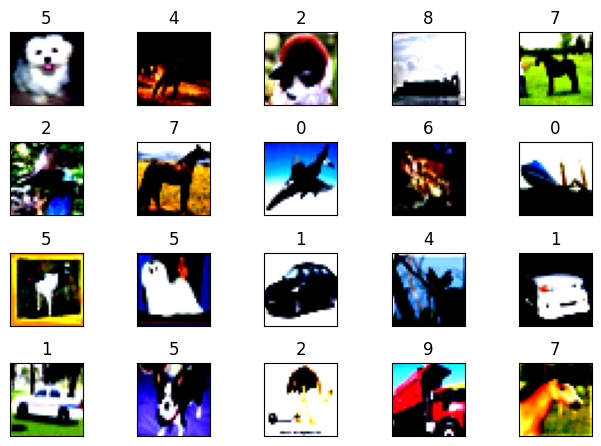

In [12]:
batch_data_test, batch_label_test = next(iter(test_loader))
figure_test = plot_images(batch_data_test, batch_label_test.tolist(), 20, 4, 'CIFAR10')
figure_test.savefig("images/test_dataset.jpg")

## Grad Cam Images

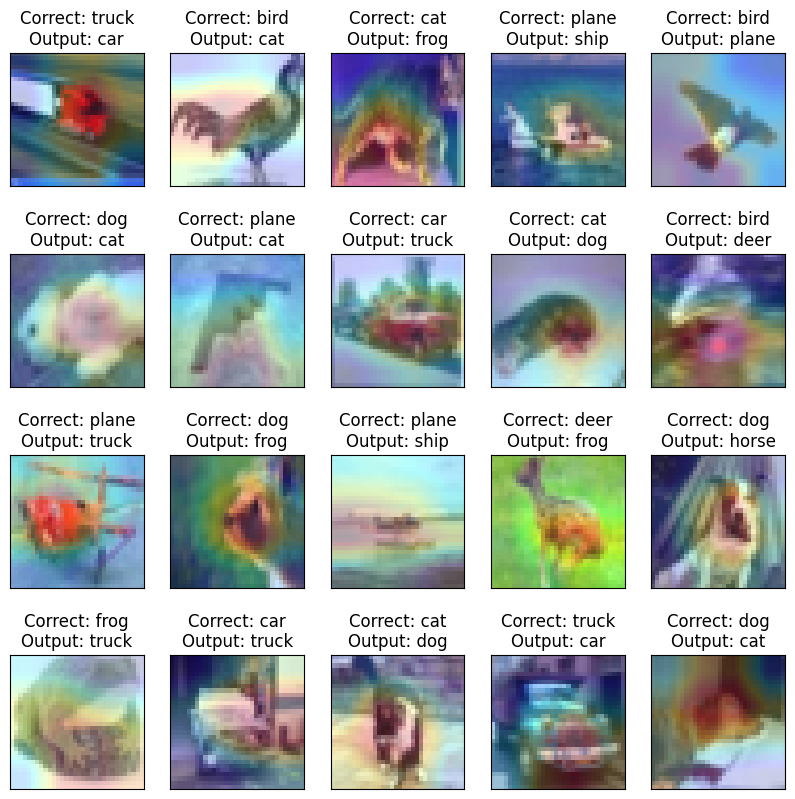

In [13]:
from utils import display_gradcam_output

# Denormalize the data using test mean and std deviation
inv_normalize = transforms.Normalize(
    mean=[-0.50/0.23, -0.50/0.23, -0.50/0.23],
    std=[1/0.23, 1/0.23, 1/0.23]
)

target_layers = [m.layer4[-1]]
targets = None

display_gradcam_output(misclassified_data, classes, inv_normalize, m, target_layers, targets, number_of_samples=20, transparency=0.80)